In [145]:
import torch
import matplotlib.pyplot as plt
from utils import Truss
from scipy.optimize import root_scalar

torch.set_default_dtype(torch.double)


# Sample truss

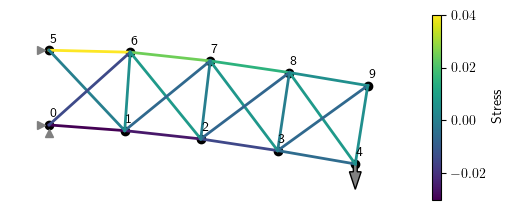

In [146]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

forces = torch.zeros_like(nodes)
forces[4, 1] = -0.1
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[5, 0] = True
x = 10 * torch.ones((len(elements)))

truss_sample = Truss(nodes, elements, forces, constraints, E=1.0)
u, f, sigma = truss_sample.solve(x)
truss_sample.plot(u=u, sigma=sigma)
plt.savefig("figures/truss_sample_solved.pdf", bbox_inches="tight")
plt.show()


## Single truss element

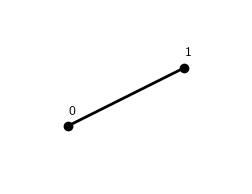

In [147]:
nodes = torch.tensor([[0.0, 0.0], [1.0, 0.5]])
elements = torch.tensor([[0, 1]])
forces = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)

plt.figure(figsize=(3, 3))
single_truss = Truss(nodes, elements, forces, constraints, E=1.0)
single_truss.plot()
plt.savefig("figures/single_truss.pdf", bbox_inches="tight")
plt.show()


## Three bar truss

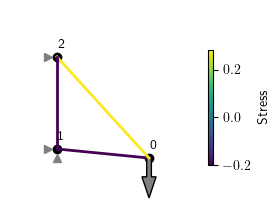

In [148]:
nodes = torch.tensor([[1.0, 0.0], [0.0, 0.0], [0.0, 1.0]])
elements = torch.tensor([[0, 1], [0, 2], [1, 2]])
forces = torch.zeros_like(nodes)
forces[0, 1] = -0.2
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[1, 0] = True
constraints[1, 1] = True
constraints[2, 0] = True
x = torch.ones((len(elements)))

plt.figure(figsize=(3, 3))
three_bar_truss = Truss(nodes, elements, forces, constraints, E=10.0)
u, f, sigma = three_bar_truss.solve(x)
three_bar_truss.plot(u=u, sigma=sigma)
plt.savefig("figures/three_bar_truss_solved.pdf", bbox_inches="tight", transparent=True)
plt.show()


## The optimization

In [149]:
def newton(mu_init, grad, max_iter=10, tol=0.0001):
    mu = torch.tensor([mu_init], requires_grad=True)
    i = 0
    # Iterate until tolerance
    while torch.abs(grad(mu)) > tol:
        print(mu.data)
        # Stop if iteration limit is reached
        if i > max_iter:
            raise Exception(f"Newton solver did not converge in {max_iter} iterations.")
        # Compute gradient of grad(mu)
        gradgrad = torch.autograd.grad(grad(mu).sum(), mu)[0]
        # Newton update
        mu.data -= grad(mu) / gradgrad
        # Constraint mu > 0
        mu.data = torch.maximum(mu.data, torch.tensor([0.0]))
        # Counter for iteration limit
        i += 1
    return mu.data


def optimize(truss, x_0, x_min, x_max, V_0, iter=10, s=0.7, mu_star=1.0):
    x = [x_0]
    L = []
    l = truss.element_lengths()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(x_min, l) > V_0 * torch.inner(x_max, l):
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the truss problem at point x_k
        u_k, f_k, sigma_k = truss.solve(x[k])

        # Get strain energy of all truss elements for the given displacement
        w_k = truss.element_strain_energies(u_k)

        # Compute lower asymptote
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1 / s * (x[k - 1][j] - L[k - 1][j])
            L.append(L_k)
        else:
            L.append(x[k] - s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])

        # Analytical solution (note that mu is scaled with sum(l)^3)
        def x_star(mu):
            EPS = 1e-15  # Trick to prevent division by zero
            x_hat = L[k] + torch.sqrt(
                (2 * w_k * (L[k] - x[k]) ** 2 + EPS) / (mu * l / l.sum() ** 3 + EPS)
            )
            return torch.maximum(torch.minimum(x_hat, x_max), x_min_k)

        # Analytical gradient
        def grad(mu):
            return torch.dot(x_star(mu), l) - V_0 * torch.dot(x_max, l)

        # Solve dual problem
        # mu_star = newton(mu_star, grad)
        opt = root_scalar(grad, bracket=[0.0, 100.0])
        mu_star = opt.root

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        x.append(x_star(mu_star))

    return x


## Optimization of the three bar truss

Iteration k=0 - Compliance: 0.07790
Iteration k=1 - Compliance: 0.04519
Iteration k=2 - Compliance: 0.03783
Iteration k=3 - Compliance: 0.03750
Iteration k=4 - Compliance: 0.03749
Iteration k=5 - Compliance: 0.03749
Iteration k=6 - Compliance: 0.03749
Iteration k=7 - Compliance: 0.03749
Iteration k=8 - Compliance: 0.03749
Iteration k=9 - Compliance: 0.03749


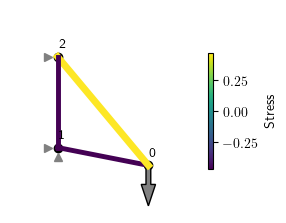

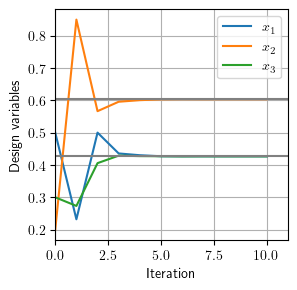

In [150]:
x_0 = torch.tensor([0.5, 0.2, 0.3])
x_min = 0.1 * torch.ones_like(x_0)
x_max = 1.0 * torch.ones_like(x_0)
V0 = 0.5

x_opt = optimize(three_bar_truss, x_0, x_min, x_max, V0)
u, f, sigma = three_bar_truss.solve(x_opt[-1])

plt.figure(figsize=(3, 3))
three_bar_truss.plot(u=u, sigma=sigma, x=x_opt[-1])
plt.savefig(
    "figures/three_bar_truss_optimized.pdf", transparent=True, bbox_inches="tight"
)
plt.show()

plt.rcParams["text.usetex"] = True

l = three_bar_truss.element_lengths()
plt.figure(figsize=(3, 3))
plt.plot(range(len(x_opt)), torch.stack(x_opt))
plt.axhline(0.25 * V0 * torch.dot(x_max, l), color="gray")
plt.axhline(0.3535 * V0 * torch.dot(x_max, l), color="gray")
plt.legend(["$x_1$", "$x_2$", "$x_3$"])
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(x_opt)])
plt.grid()
plt.savefig(
    "figures/three_bar_truss_variables.pdf", transparent=True, bbox_inches="tight"
)
plt.show()


## Optimization of the sample truss

Iteration k=0 - Compliance: 0.10004
Iteration k=1 - Compliance: 0.03018
Iteration k=2 - Compliance: 0.03039
Iteration k=3 - Compliance: 0.02943
Iteration k=4 - Compliance: 0.02927
Iteration k=5 - Compliance: 0.02898
Iteration k=6 - Compliance: 0.02892
Iteration k=7 - Compliance: 0.02886
Iteration k=8 - Compliance: 0.02883
Iteration k=9 - Compliance: 0.02882
Iteration k=10 - Compliance: 0.02882
Iteration k=11 - Compliance: 0.02882
Iteration k=12 - Compliance: 0.02882
Iteration k=13 - Compliance: 0.02882
Iteration k=14 - Compliance: 0.02882
Iteration k=15 - Compliance: 0.02882
Iteration k=16 - Compliance: 0.02882
Iteration k=17 - Compliance: 0.02882
Iteration k=18 - Compliance: 0.02882
Iteration k=19 - Compliance: 0.02882
Iteration k=20 - Compliance: 0.02882
Iteration k=21 - Compliance: 0.02882
Iteration k=22 - Compliance: 0.02882
Iteration k=23 - Compliance: 0.02882
Iteration k=24 - Compliance: 0.02882
Iteration k=25 - Compliance: 0.02882
Iteration k=26 - Compliance: 0.02882
Iteration k

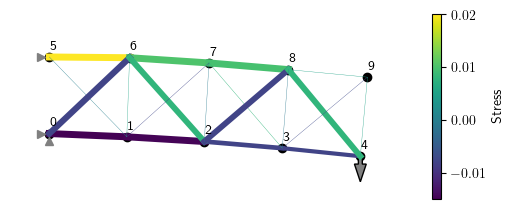

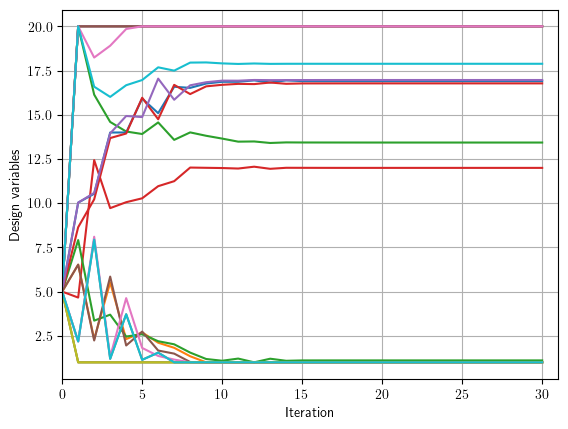

In [151]:
x_0 = 5.0 * torch.ones((len(truss_sample.elements)))
x_min = 1.0 * torch.ones_like(x_0)
x_max = 20.0 * torch.ones_like(x_0)
V0 = 0.5

x_opt = optimize(truss_sample, x_0, x_min, x_max, V0, iter=30)
u, f, sigma = truss_sample.solve(x_opt[-1])
truss_sample.plot(u=u, sigma=sigma, x=x_opt[-1])
plt.savefig("figures/truss_sample_optimized.pdf", transparent=True, bbox_inches="tight")
plt.show()

# plt.rcParams["text.usetex"] = True

plt.plot(range(len(x_opt)), torch.stack(x_opt))
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(x_opt)])
plt.grid()
# plt.savefig("figures/truss_sample_variables.pdf", transparent=True)
plt.show()


## A large truss system with 136 elements

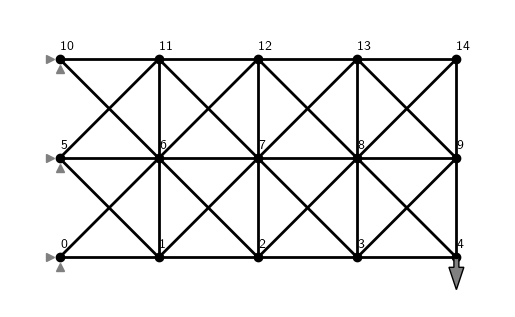

In [170]:
A = 5
B = 3
n1 = torch.linspace(0.0, A - 1.0, A)
n2 = torch.linspace(0.0, B - 1.0, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elem = []
for i in range(A - 1):
    for j in range(B):
        elem.append([i + j * A, i + 1 + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elem.append([i + 1 + j * A, i + 1 + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elem.append([i + j * A, i + 1 + A + j * A])
        elem.append([i + 1 + j * A, i + A + j * A])

elements = torch.tensor(elem)

forces = torch.zeros_like(nodes)
forces[A - 1, 1] = -0.1
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
for i in range(B):
    constraints[i * A, 0] = True
    constraints[i * A, 1] = True

large_truss = Truss(nodes, elements, forces, constraints, E=100.0)
large_truss.plot()


## Optimization

Iteration k=0 - Compliance: 0.00064
Iteration k=1 - Compliance: 0.00016
Iteration k=2 - Compliance: 0.00036
Iteration k=3 - Compliance: 0.00077
Iteration k=4 - Compliance: 0.00025
Iteration k=5 - Compliance: 0.00026
Iteration k=6 - Compliance: 0.00098
Iteration k=7 - Compliance: 0.00012
Iteration k=8 - Compliance: 0.00019
Iteration k=9 - Compliance: 0.00021
Iteration k=10 - Compliance: 0.00019
Iteration k=11 - Compliance: 0.00024
Iteration k=12 - Compliance: 0.00033
Iteration k=13 - Compliance: 0.00023
Iteration k=14 - Compliance: 0.00036
Iteration k=15 - Compliance: 0.00026
Iteration k=16 - Compliance: 0.00024
Iteration k=17 - Compliance: 0.00021
Iteration k=18 - Compliance: 0.00027
Iteration k=19 - Compliance: 0.00022
Iteration k=20 - Compliance: 0.00023
Iteration k=21 - Compliance: 0.00028
Iteration k=22 - Compliance: 0.00030
Iteration k=23 - Compliance: 0.00016
Iteration k=24 - Compliance: 0.00011
Iteration k=25 - Compliance: 0.00015
Iteration k=26 - Compliance: 0.00018
Iteration k

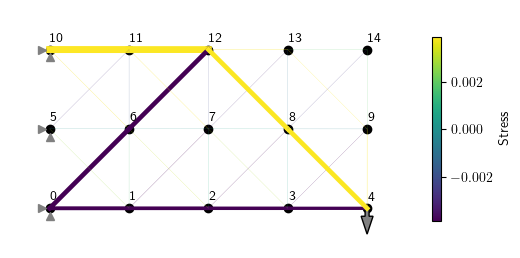

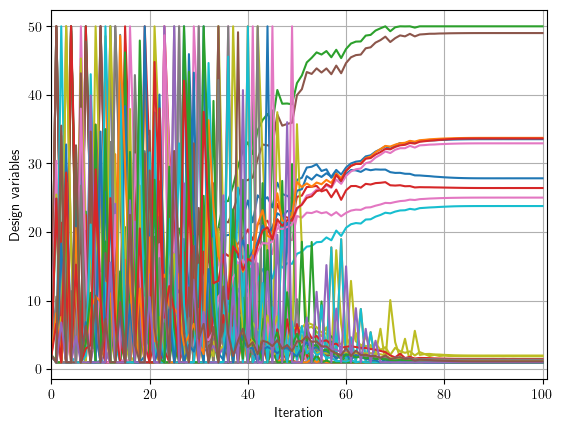

In [171]:
x_0 = 2.0 * torch.ones((len(large_truss.elements)))
x_min = 1.0 * torch.ones_like(x_0)
x_max = 50.0 * torch.ones_like(x_0)
V0 = 0.20
x_opt = optimize(large_truss, x_0, x_min, x_max, V0, iter=100, s=0.9)
u, f, sigma = large_truss.solve(x_opt[-1])
large_truss.plot(u=u, sigma=sigma, x=x_opt[-1])
plt.show()
# for i in [0, 5, 15, 40, 60, 100, 140, 200, 260]:
#     u, f, sigma = large_truss.solve(x_opt[i])
#     large_truss.plot(u=u, sigma=sigma, x=x_opt[i])
#     plt.show()

plt.plot(range(len(x_opt)), torch.stack(x_opt))
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(x_opt)])
plt.grid()
plt.show()
